In [1]:
from transformers import ViTForImageClassification
from torch import nn

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
model.classifier = nn.Linear(model.config.hidden_size, 1)

/home/emir/miniconda3/envs/vclfs/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
import ast

def extract_rank(row):
    return row['rank'] if row and 'rank' in row else None

def convert_to_dict(string_repr):
    try:
        return ast.literal_eval(string_repr)
    except (SyntaxError, ValueError):
        return None

In [6]:
valid_list = ["azuki",
"sappy-seals",
"killabears",
"lazy-lions",
"genuine-undead",
"genesis-creepz",
"bastard-gan-punks-v2",
"pudgypenguins",
"beanzofficial",
"ninja-squad-official",
"azragames-thehopeful",
"thewarlords",
"parallel-avatars",
"pixelmongen1",
"kanpai-pandas"]
labels_dir = "/home/emir/Desktop/dev/datasets/nft_dataset/labels_augmented.csv"

In [10]:
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, random_split
import math
import numpy as np
import os
import ast
import torch
from PIL import Image


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class RarityDataset(Dataset):
    def __init__(self, csv_dir, col_names, image_dir, transform):
        self.labels = pd.read_csv(csv_dir)
        self.col_names = col_names
        self.transform = transform
        self.labels['dict'] = self.labels['label'].apply(convert_to_dict)
        self.labels['rank_values'] = self.labels["dict"].apply(extract_rank)
        self.col_max_rarity = self.calculate_rarity()
        self.col_name = None
        # self.drop_nan_ones()
        self.image_dir = image_dir

    def drop_nan_ones(self):
        max_col_rarity = self.col_max_rarity.copy()
        self.collection_drop = []
        for key, val in max_col_rarity.items():
            if math.isnan(val):
                print(f"{key}:{val}")
                self.col_max_rarity.pop(key)
                self.collection_drop.append(key)
        for key in self.collection_drop:
            self.labels.drop(self.labels[self.labels['data_name'].str.startswith(key)].index, inplace=True)
        self.labels.dropna(inplace=True)
        self.labels.reset_index(inplace=True)

    def __len__(self):
        return len(self.labels)

    def calculate_rarity(self):
        max_col_rarities = {}
        for col in self.col_names:
            filtered_df = self.labels[self.labels["data_name"].str.startswith(col)]
            max_col_rarities[col] = filtered_df["rank_values"].max()
        return max_col_rarities

    def get_col_labels(self, col_name):
        return self.labels[self.labels['data_name'].str.startswith(col_name)].index
    
    def __getitem__(self, index):
        self.col_name = self.labels['data_name'][index].split("_")[0] # bu olabilir
        img_dir = os.path.join(self.image_dir, self.labels['data_name'][index])
        img = np.array(Image.open(img_dir).convert('RGB'))
        if self.transform:
            img = self.transform(img)
        return img, self.labels['cls'][index]
    
rarity_dataset = RarityDataset(labels_dir, valid_list, "/home/emir/Desktop/dev/datasets/nft_dataset/NFT_DATASET_MERGED/train/new_collection", transform=transform)

In [11]:

train_size = int(0.8 * len(rarity_dataset))
test_size = len(rarity_dataset) - train_size

train_dataset, test_dataset = random_split(rarity_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [12]:
rarity_dataset[0]

/home/emir/miniconda3/envs/vclfs/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(tensor([[[-0.9020, -0.9020, -0.9020,  ..., -0.9020, -0.9020, -0.9020],
          [-0.9020, -0.9020, -0.9020,  ..., -0.9020, -0.9020, -0.9020],
          [-0.9020, -0.9020, -0.9020,  ..., -0.9020, -0.9020, -0.9020],
          ...,
          [-0.9020, -0.9020, -0.9020,  ..., -0.9020, -0.9020, -0.9020],
          [-0.9020, -0.9020, -0.9020,  ..., -0.9020, -0.9020, -0.9020],
          [-0.9020, -0.9020, -0.9020,  ..., -0.9020, -0.9020, -0.9020]],
 
         [[ 0.6779,  0.6779,  0.6779,  ...,  0.6779,  0.6779,  0.6779],
          [ 0.6779,  0.6779,  0.6779,  ...,  0.6779,  0.6779,  0.6779],
          [ 0.6779,  0.6779,  0.6779,  ...,  0.6779,  0.6779,  0.6779],
          ...,
          [ 0.6779,  0.6779,  0.6779,  ...,  0.6779,  0.6779,  0.6779],
          [ 0.6779,  0.6779,  0.6779,  ...,  0.6779,  0.6779,  0.6779],
          [ 0.6779,  0.6779,  0.6779,  ...,  0.6779,  0.6779,  0.6779]],
 
         [[-0.3055, -0.3055, -0.3055,  ..., -0.3055, -0.3055, -0.3055],
          [-0.3055, -0.3055,

In [13]:
model.load_state_dict(torch.load("/home/emir/Desktop/dev/datasets/nft_rarity_dataset/weights/run_01_clsf.pt"))

FileNotFoundError: [Errno 2] No such file or directory: '/home/emir/Desktop/dev/datasets/nft_rarity_dataset/weights/run_01_clsf.pt'

/home/emir/miniconda3/envs/vclfs/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/emir/miniconda3/envs/vclfs/lib/python3.8/site-packages/PIL/Image.py:3182: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852


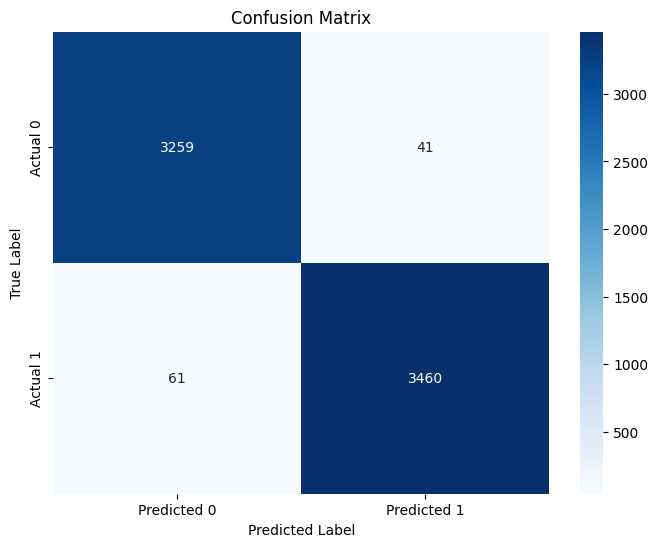

Accuracy: 0.9850461809118898
F1 Score: 0.9854742238678439
Precision Score: 0.9882890602684947


In [62]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
import torch
import seaborn as sns
import matplotlib.pyplot as plt

model.to("cuda")
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        print(i)
        img, label = batch
        output = model(img.to("cuda"))

        true_labels.extend(label.numpy())
        predicted_labels.extend((torch.sigmoid(output.logits).detach().cpu().numpy() > 0.5).astype(int))

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate metrics
acc = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
p_score = precision_score(true_labels, predicted_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {acc}')
print(f'F1 Score: {f1}')
print(f'Precision Score: {p_score}')

In [56]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np
import cv2

# seq = iaa.Sequential([
#     iaa.Resize({"height": 224, "width": 224}),
#     iaa.Fliplr(0.5),
#     iaa.Crop(percent=(0, 0.1)),
#     iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
#     iaa.ContrastNormalization((0.75, 1.5)),
#     iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
#     iaa.Multiply((0.8, 1.2), per_channel=0.2),
#     iaa.Affine(rotate=(-45, 45), shear=(-16, 16), mode=ia.ALL),
#     iaa.PiecewiseAffine(scale=(0.01, 0.05)),
#     iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True),
#     iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25),
# ], random_order=True)

seq = iaa.Sequential([
    iaa.Resize({"height": 224, "width": 224}),
], random_order=True)


In [32]:
model.to("cuda")

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [37]:
df = pd.read_csv("/home/emir/Desktop/dev/datasets/nft_rarity_dataset/labels_augmented.csv")

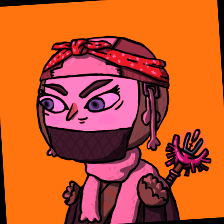

predicted result: rare, real label: rare


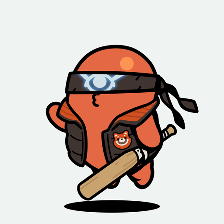

predicted result: common, real label: common


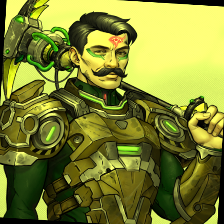

predicted result: rare, real label: rare
index 0 is out of bounds for axis 0 with size 0


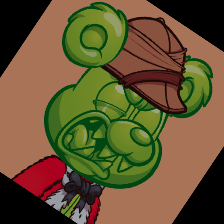

predicted result: rare, real label: rare


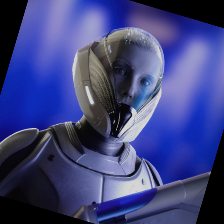

predicted result: rare, real label: rare


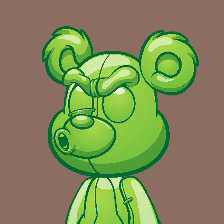

predicted result: common, real label: common
index 0 is out of bounds for axis 0 with size 0


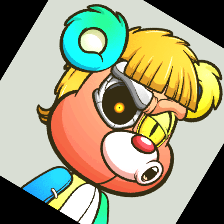

predicted result: rare, real label: rare


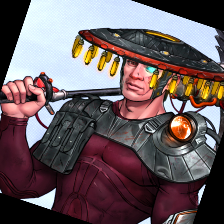

predicted result: rare, real label: rare


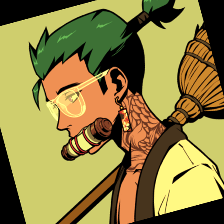

predicted result: rare, real label: rare


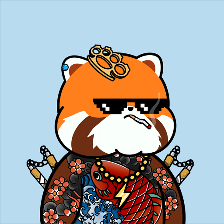

predicted result: rare, real label: common
index 0 is out of bounds for axis 0 with size 0


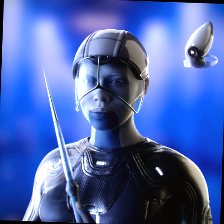

predicted result: rare, real label: rare


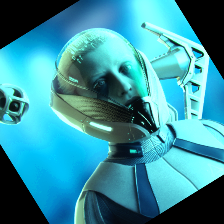

predicted result: rare, real label: rare


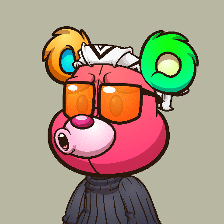

predicted result: rare, real label: rare


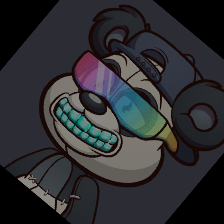

predicted result: rare, real label: rare
index 0 is out of bounds for axis 0 with size 0


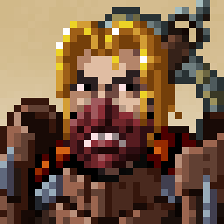

predicted result: rare, real label: common


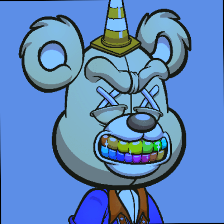

predicted result: rare, real label: rare


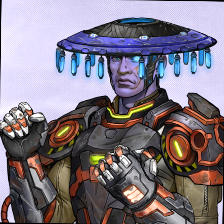

predicted result: rare, real label: rare


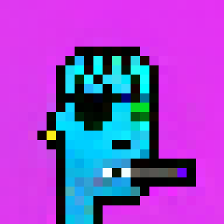

predicted result: rare, real label: common


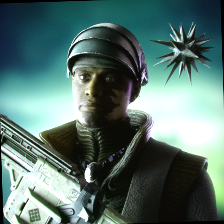

predicted result: rare, real label: rare


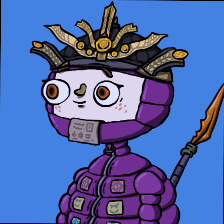

predicted result: rare, real label: rare


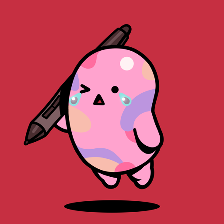

predicted result: common, real label: common


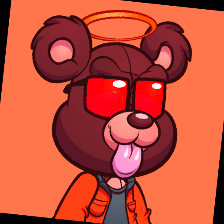

predicted result: common, real label: rare


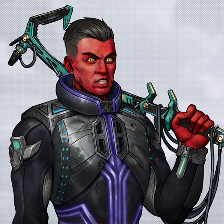

predicted result: rare, real label: common


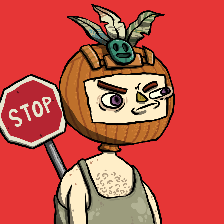

predicted result: common, real label: common


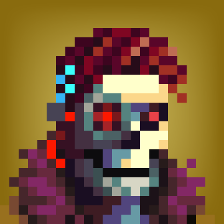

predicted result: rare, real label: common


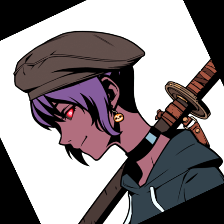

predicted result: rare, real label: rare
index 0 is out of bounds for axis 0 with size 0


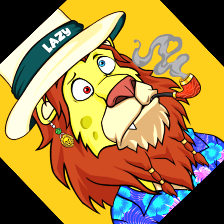

predicted result: rare, real label: rare


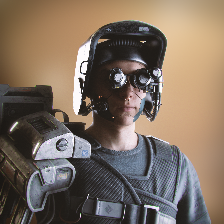

predicted result: common, real label: common


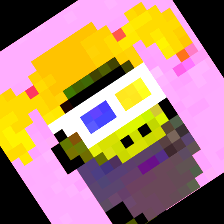

predicted result: rare, real label: rare


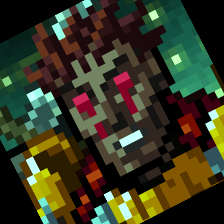

predicted result: rare, real label: rare
index 0 is out of bounds for axis 0 with size 0


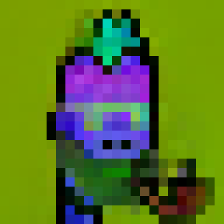

predicted result: rare, real label: common
index 0 is out of bounds for axis 0 with size 0


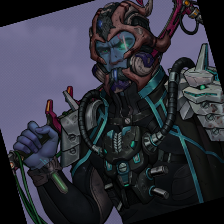

predicted result: rare, real label: rare


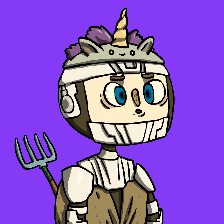

predicted result: rare, real label: common


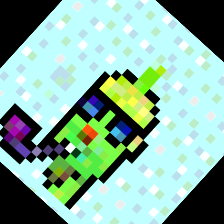

predicted result: rare, real label: rare


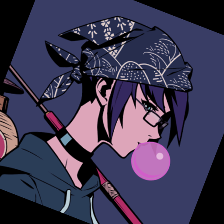

predicted result: common, real label: rare


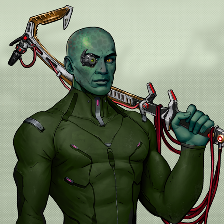

predicted result: rare, real label: common


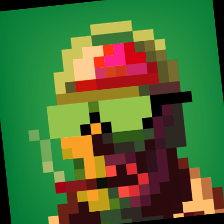

predicted result: rare, real label: rare


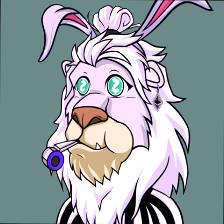

predicted result: common, real label: rare


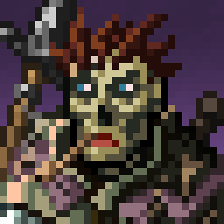

predicted result: rare, real label: common


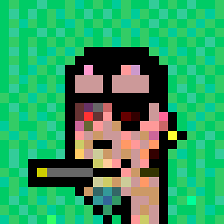

predicted result: rare, real label: rare


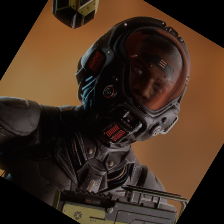

predicted result: rare, real label: rare


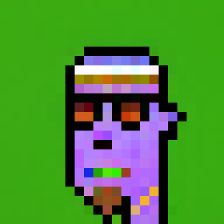

predicted result: rare, real label: common


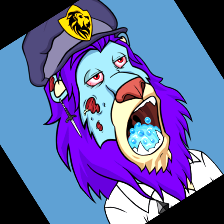

predicted result: rare, real label: rare


In [57]:
from IPython.display import display
from PIL import Image
import numpy as np

imgs_dir = "/home/emir/Desktop/dev/datasets/nft_rarity_dataset/rarity_dataset_augmented/rarity_dataset_augmented"

model.eval()
with torch.no_grad():
    for _ in range(50):
        random_indx = np.random.randint(len(os.listdir(imgs_dir)))
        img_path = os.path.join(imgs_dir, os.listdir(imgs_dir)[random_indx])
        data_name = img_path.split('/')[-1]
        try:
            real_label = "rare" if df[df['data_name'] == data_name]['cls'].values[0] else "common"
            # print(real_label)
            img_bgr = cv2.imread(img_path)

        
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

            
            img_augmented = seq.augment_image(img_rgb)

            
            img_tensor = torch.FloatTensor(img_augmented).permute(2, 0, 1).unsqueeze(0).to("cuda")

            
            output = model(img_tensor)
            result = "rare" if torch.sigmoid(output.logits) >= 0.5 else "common"

            
            image = Image.fromarray(img_augmented.astype('uint8'))
            display(image)

            print(f"predicted result: {result}, real label: {real_label}")
        except Exception as e:
            print(e)
        
    
    